# LifeSnaps Preprocessing Data
Aquest model de predicció agafa unicament els valors registrats tant en el TRAIN com en el TEST. Per tant no es fa imputacio de dades.

### Import de llibreries i warnings

In [120]:
# Exploració de dades
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessament de dades
from sklearn.preprocessing import StandardScaler,  OneHotEncoder
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Model
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Analisis del model
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

In [23]:
import warnings
warnings.filterwarnings('ignore')

## Lectura del dataset cleaned

In [24]:
df = pd.read_csv('../data/df_cleaned.csv')
pd.set_option('display.max_columns', None)

display(df.head())
df.info()


,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,daily_temperature_variation,calories,bpm,lightly_active_minutes,moderately_active_minutes,very_active_minutes,sedentary_minutes,resting_hr,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio,steps,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,age,gender,bmi,RESTED/RELAXED,TENSE/ANXIOUS
0,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,-2.462709,2332.08,70.579300,132.0,25.0,31.0,704.0,62.121476,0.0,460.0,88.0,0.0,94.0,1.466667,1.142857,0.947566,1.197531,9727.0,56.0,1374.0,4.0,0.0,<30,MALE,<19,0.0,0.0
1,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,-2.385801,2262.30,71.842573,112.0,27.0,31.0,710.0,62.263999,0.0,493.0,67.0,0.0,96.0,1.116883,0.858974,1.015038,1.670732,8253.0,85.0,1350.0,0.0,0.0,<30,MALE,<19,0.0,0.0
2,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,-2.124199,2325.10,71.725477,133.0,21.0,37.0,622.0,62.368900,0.0,540.0,87.0,0.0,93.0,1.128205,1.129870,1.191729,1.588235,9015.0,90.0,1282.0,0.0,0.0,<30,MALE,<19,0.0,0.0
3,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,-2.396873,2586.76,74.401028,136.0,42.0,54.0,647.0,61.965409,0.0,493.0,68.0,0.0,94.0,0.910256,0.871795,1.211896,1.090909,12949.0,146.0,1274.0,4.0,0.0,<30,MALE,<19,0.0,0.0
4,2021-05-29,34.610929,57.314,89.941,NaN,14.8,82.0,0.900000,-2.638646,3806.02,83.739770,305.0,128.0,98.0,371.0,62.671748,0.0,471.0,67.0,6.0,95.0,0.846154,0.870130,1.110294,1.170455,25526.0,428.0,986.0,2.0,0.0,<30,MALE,<19,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date                          2290 non-null   object 
 1   nightly_temperature           1717 non-null   float64
 2   nremhr                        1179 non-null   float64
 3   rmssd                         1179 non-null   float64
 4   spo2                          706 non-null    float64
 5   full_sleep_breathing_rate     1193 non-null   float64
 6   stress_score                  1041 non-null   float64
 7   sleep_points_percentage       1041 non-null   float64
 8   daily_temperature_variation   1699 non-null   float64
 9   calories                      2243 non-null   float64
 10  bpm                           2067 non-null   float64
 11  lightly_active_minutes        2243 non-null   float64
 12  moderately_active_minutes     2243 non-null   float64
 13  ver

## Preprocessament de dades

In [33]:
# Definim els targets
targets = ['TENSE/ANXIOUS', 'RESTED/RELAXED']
date = ['date']

y = df[targets].copy()
y_tense = y['TENSE/ANXIOUS']
y_rested = y['RESTED/RELAXED']

X = df.drop(columns=targets + date).copy()

print(y.info(), '\n\n')
print(X.info())

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categoric_cols = X.select_dtypes(include=['category', 'object', 'bool']).columns.tolist()

print(f"Nº variables numéricas: {len(numeric_cols)}")
print(f"Nº variables categóricas: {len(categoric_cols)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TENSE/ANXIOUS   2290 non-null   float64
 1   RESTED/RELAXED  2290 non-null   float64
dtypes: float64(2)
memory usage: 35.9 KB
None 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   nightly_temperature           1717 non-null   float64
 1   nremhr                        1179 non-null   float64
 2   rmssd                         1179 non-null   float64
 3   spo2                          706 non-null    float64
 4   full_sleep_breathing_rate     1193 non-null   float64
 5   stress_score                  1041 non-null   float64
 6   sleep_points_percentage       1041 non-null   float64
 7   daily_temperature_vari

In [26]:
# Transformem les columnes amb pipeline

numeric_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),
                        ("scaler", StandardScaler())])

categoric_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),
                            ("encoder", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer([
    ("num", numeric_pipe, numeric_cols),
    ("cat", categoric_pipe, categoric_cols)
])

display(preprocessor)



ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['nightly_temperature', 'nremhr', 'rmssd',
                                  'spo2', 'full_sleep_breathing_rate',
                                  'stress_score', 'sleep_points_percentage',
                                  'daily_temperature_variation', 'calories',
                                  'bpm', 'lightly_active_minutes',
                                  'moderately_active_minutes',
                                  'ver...
                                  'sleep_deep_ratio', 'sleep_wake_ratio',
                                  'sleep_light_ratio', 'sleep_rem_ratio',
                                  'steps', 'minutes_in_default_zone_1',
                                  'minutes_below_default_zone_1',
                                  'minutes_in_default_zone_2',
                                  'minutes_in_default_zone_3']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['age', 'gender', 'bmi'])])

In [27]:
# Visualitzem el dataset preprocessat
X_processed = preprocessor.fit_transform(X)

# Obtenim els noms de les columnes després del pre-processament
noms_columnes = numeric_cols + list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categoric_cols))

df_X_prepocessed = pd.DataFrame(X_processed, columns=noms_columnes)

display(df_X_prepocessed.head())
print(df_X_prepocessed.info())

,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,daily_temperature_variation,calories,bpm,lightly_active_minutes,moderately_active_minutes,very_active_minutes,sedentary_minutes,resting_hr,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio,steps,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,age_<30,age_>=30,gender_FEMALE,gender_MALE,bmi_19.0,bmi_20.0,bmi_21.0,bmi_22.0,bmi_23.0,bmi_24.0,bmi_25.0,bmi_26.0,bmi_27.0,bmi_28.0,bmi_29.0,bmi_<19,bmi_>=25,bmi_>=30
0,-0.132237,-0.438049,3.577308,0.029145,0.617053,0.445085,0.530875,-1.204693,-0.174882,-0.926754,-0.595619,0.108982,0.259118,-0.439403,-0.441751,-0.040343,0.736113,1.542179,-0.231885,0.026573,1.661520,0.595825,-0.242700,0.654418,0.193324,-0.782494,1.057876,-0.194630,-0.194575,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.022597,-0.464089,5.186093,0.029145,0.081874,0.663059,1.211846,-1.111750,-0.272667,-0.782066,-0.783526,0.179861,0.259118,-0.418224,-0.421544,-0.040343,1.117872,0.514886,-0.231885,0.317037,0.424419,-0.494629,0.107226,2.210001,-0.093492,-0.598704,0.976810,-0.387867,-0.194575,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.735883,-0.462527,4.701501,0.029145,0.171070,0.554072,1.041603,-0.795607,-0.184663,-0.795478,-0.586224,-0.032778,0.434544,-0.728847,-0.406670,-0.040343,1.661589,1.493260,-0.231885,-0.118659,0.464462,0.545939,1.023592,1.938806,0.054781,-0.567016,0.747125,-0.387867,-0.194575,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.411438,-0.559266,4.141213,0.029145,0.349463,0.499578,0.701118,-1.125130,0.182009,-0.489035,-0.558038,0.711460,0.931585,-0.640602,-0.463879,-0.040343,1.117872,0.563804,-0.231885,0.026573,-0.306371,-0.445383,1.128181,0.303913,0.820274,-0.212112,0.720103,-0.194630,-0.194575,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.022482,-0.485833,3.295582,0.029145,0.171070,0.554072,0.871360,-1.417311,1.890596,0.580572,1.029774,3.759290,2.218044,-1.614827,-0.363731,-0.040343,0.863366,0.514886,1.624815,0.171805,-0.533087,-0.451779,0.601250,0.565408,3.267555,1.575083,-0.252682,-0.291248,-0.194575,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 47 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   nightly_temperature           2290 non-null   float64
 1   nremhr                        2290 non-null   float64
 2   rmssd                         2290 non-null   float64
 3   spo2                          2290 non-null   float64
 4   full_sleep_breathing_rate     2290 non-null   float64
 5   stress_score                  2290 non-null   float64
 6   sleep_points_percentage       2290 non-null   float64
 7   daily_temperature_variation   2290 non-null   float64
 8   calories                      2290 non-null   float64
 9   bpm                           2290 non-null   float64
 10  lightly_active_minutes        2290 non-null   float64
 11  moderately_active_minutes     2290 non-null   float64
 12  very_active_minutes           2290 non-null   float64
 13  sed

In [ ]:
## Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_tense,test_size=0.2, random_state=42, stratify=y_tense)


## Entrenament del Model (SMOTE)

In [130]:
# Definició de models i paràmetres
models = {
    "MLP": MLPClassifier(max_iter=400, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Definim els grids de paràmetres amb prefix
param_grids = {
    "MLP": {
        "clf__hidden_layer_sizes": [(100,), (50,50), (100,50)],
        "clf__alpha": [1e-4, 1e-3],
        "clf__learning_rate_init": [1e-3, 1e-2]
    },
    "SVM": {
        "clf__C": [1, 10, 50],
        "clf__gamma": ["scale", 1e-2, 1e-3]
    },
    "RandomForest": {
        "clf__n_estimators": [300, 600],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5]
    },
    "GradientBoosting": {
        "clf__n_estimators": [150, 300],
        "clf__learning_rate": [0.1, 0.05],
        "clf__max_depth": [3, 4]
    }
}

# Cross‑validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop de GridSearchCV
results = []

for nom, model in models.items():
    print(f"\nBuscant els millors paràmetres amb GridSearchCV per {nom}")
    pipeline = ImbPipeline([
        ("prep", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", model)
    ])
    gs = GridSearchCV(
        pipeline,
        param_grid=param_grids[nom],
        cv=cv,
        scoring="recall",
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X_train, y_train)

    # Emmagatzema resultats
    results.append({
        "model":       nom,
        "millor_sensibilitat": gs.best_score_,
        "millors_parametres": gs.best_params_
    })

    print(f"{nom} → Millor Sensibilitat: {gs.best_score_:.3f}")
    print("Params òptims:", gs.best_params_)

# 5) Converteix a DataFrame i mostra ordenat
results_df = pd.DataFrame(results).sort_values(
    by="millor_sensibilitat", ascending=False
).reset_index(drop=True)


 Buscant els millors paràmetres amb GridSearchCV per MLP
MLP → Millor Sensibilitat: 0.333
Params òptims: {'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.01}

 Buscant els millors paràmetres amb GridSearchCV per SVM
SVM → Millor Sensibilitat: 0.752
Params òptims: {'clf__C': 1, 'clf__gamma': 0.001}

 Buscant els millors paràmetres amb GridSearchCV per RandomForest
RandomForest → Millor Sensibilitat: 0.315
Params òptims: {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}

 Buscant els millors paràmetres amb GridSearchCV per GradientBoosting
GradientBoosting → Millor Sensibilitat: 0.305
Params òptims: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 150}


In [99]:
display(results_df)

,model,millor_sensibilitat,millors_parametres
0,SVM,0.752222,"{'clf__C': 1, 'clf__gamma': 0.001}"
1,MLP,0.332593,"{'clf__alpha': 0.001, 'clf__hidden_layer_sizes..."
2,RandomForest,0.315216,"{'clf__max_depth': 10, 'clf__min_samples_split..."
3,GradientBoosting,0.305154,"{'clf__learning_rate': 0.05, 'clf__max_depth':..."


### Tria del millor model i pipeline (SMOTE)



Millor model: SVM

Mètriques sobre test:
 • Exactitud (Accuracy) :  0.701
 • Precisió             :  0.366
 • Sensibilitat         :  0.485
 • F1-score             :  0.417
 • ROC-AUC              :  0.661



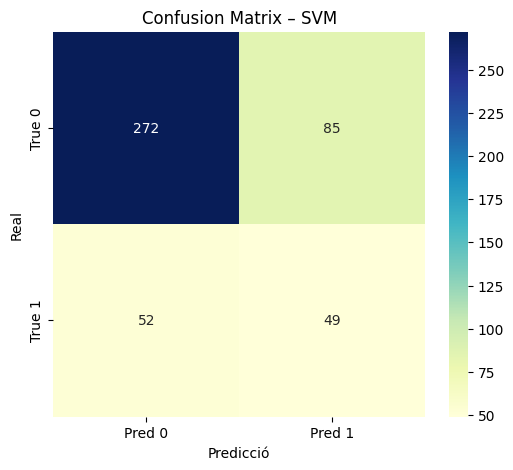

In [ ]:

# millor model

millor_model = results_df.iloc[0].to_dict()
model_name   = millor_model["model"]
print(f"\nMillor model: {model_name}\n")

# Reentrena pipeline amb el model escollit
best_estimator = models[model_name]
millor_pipeline = ImbPipeline([
    ("prep",  preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf",   best_estimator)
])
millor_pipeline.fit(X_train, y_train)


# Prediccions
y_pred = millor_pipeline.predict(X_test)
y_pred_proba = millor_pipeline.predict_proba(X_test)[:, 1]


# Mètriques numèriques
acc     = accuracy_score(y_test, y_pred)
prec    = precision_score(y_test, y_pred)
rec     = recall_score(y_test, y_pred)
f1      = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Mètriques sobre test:")
print(f" • Exactitud (Accuracy) :  {acc:.3f}")
print(f" • Precisió             :  {prec:.3f}")
print(f" • Sensibilitat         :  {rec:.3f}")
print(f" • F1-score             :  {f1:.3f}")
print(f" • ROC-AUC              :  {roc_auc:.3f}\n")


# Matriu de confusió
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"]
)
plt.title(f"Confusion Matrix – {model_name}")
plt.ylabel("Real")
plt.xlabel("Predicció")
plt.show()

## Entrenament del Model (BorderlineSMOTE)

In [122]:
# Definició de models i paràmetres
models = {
    "MLP": MLPClassifier(max_iter=400, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Definim els grids de paràmetres amb prefix
param_grids = {
    "MLP": {
        "clf__hidden_layer_sizes": [(100,), (50,50), (100,50)],
        "clf__alpha": [1e-4, 1e-3],
        "clf__learning_rate_init": [1e-3, 1e-2]
    },
    "SVM": {
        "clf__C": [1, 10, 50],
        "clf__gamma": ["scale", 1e-2, 1e-3]
    },
    "RandomForest": {
        "clf__n_estimators": [300, 600],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5]
    },
    "GradientBoosting": {
        "clf__n_estimators": [150, 300],
        "clf__learning_rate": [0.1, 0.05],
        "clf__max_depth": [3, 4]
    }
}

# Cross‑validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop de GridSearchCV
results = []

for nom, model in models.items():
    print(f"\n Buscant els millors paràmetres amb GridSearchCV per {nom}")
    pipeline = ImbPipeline([
        ("prep", preprocessor),
        ("smote", BorderlineSMOTE(sampling_strategy=0.8, random_state=42)),
        ("clf", model)
    ])
    gs = GridSearchCV(
        pipeline,
        param_grid=param_grids[nom],
        cv=cv,
        scoring="recall",
        n_jobs=-1,
        verbose=2
    )
    gs.fit(X_train, y_train)

    # Emmagatzema resultats
    results.append({
        "model":       nom,
        "millor_sensibilitat": gs.best_score_,
        "millors_parametres": gs.best_params_
    })

    print(f"{nom} → Millor Sensibilitat: {gs.best_score_:.3f}")
    print("Params òptims:", gs.best_params_)

# 5) Converteix a DataFrame i mostra ordenat
results_df = pd.DataFrame(results).sort_values(
    by="millor_sensibilitat", ascending=False
).reset_index(drop=True)


 Buscant els millors paràmetres amb GridSearchCV per MLP
Fitting 5 folds for each of 12 candidates, totalling 60 fits
MLP → Millor Sensibilitat: 0.357
Params òptims: {'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50, 50), 'clf__learning_rate_init': 0.001}

 Buscant els millors paràmetres amb GridSearchCV per SVM
Fitting 5 folds for each of 9 candidates, totalling 45 fits
SVM → Millor Sensibilitat: 0.449
Params òptims: {'clf__C': 50, 'clf__gamma': 0.001}

 Buscant els millors paràmetres amb GridSearchCV per RandomForest
Fitting 5 folds for each of 12 candidates, totalling 60 fits
RandomForest → Millor Sensibilitat: 0.251
Params òptims: {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}

 Buscant els millors paràmetres amb GridSearchCV per GradientBoosting
Fitting 5 folds for each of 8 candidates, totalling 40 fits
GradientBoosting → Millor Sensibilitat: 0.241
Params òptims: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 300}


In [123]:
display(results_df)

,model,millor_sensibilitat,millors_parametres
0,SVM,0.449444,"{'clf__C': 50, 'clf__gamma': 0.001}"
1,MLP,0.357407,"{'clf__alpha': 0.001, 'clf__hidden_layer_sizes..."
2,RandomForest,0.250710,"{'clf__max_depth': 10, 'clf__min_samples_split..."
3,GradientBoosting,0.240679,"{'clf__learning_rate': 0.1, 'clf__max_depth': ..."


### Tria del millor model i pipeline (BorderlineSMOTE)


Millor model: SVM

Mètriques sobre test:
 • Exactitud (Accuracy) :  0.716
 • Precisió             :  0.382
 • Sensibilitat         :  0.465
 • F1-score             :  0.420
 • ROC-AUC              :  0.666



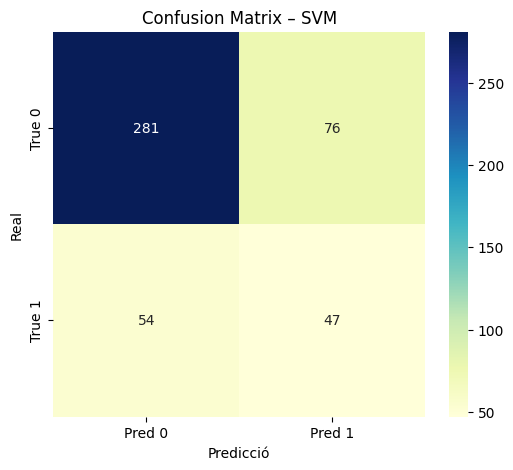

In [ ]:
# millor model

millor_model = results_df.iloc[0].to_dict()
model_name   = millor_model["model"]
print(f"\nMillor model: {model_name}\n")

# Reentrena pipeline amb el model escollit
best_estimator = models[model_name]
millor_pipeline = ImbPipeline([
    ("prep",  preprocessor),
    ("smote", BorderlineSMOTE(sampling_strategy=0.8, random_state=42)),
    ("clf",   best_estimator)
])
millor_pipeline.fit(X_train, y_train)


# Prediccions
y_pred = millor_pipeline.predict(X_test)
y_pred_proba = millor_pipeline.predict_proba(X_test)[:, 1]


# Mètriques numèriques
acc     = accuracy_score(y_test, y_pred)
prec    = precision_score(y_test, y_pred)
rec     = recall_score(y_test, y_pred)
f1      = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Mètriques sobre test:")
print(f" • Exactitud (Accuracy) :  {acc:.3f}")
print(f" • Precisió             :  {prec:.3f}")
print(f" • Sensibilitat         :  {rec:.3f}")
print(f" • F1-score             :  {f1:.3f}")
print(f" • ROC-AUC              :  {roc_auc:.3f}\n")


# Matriu de confusió
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"]
)
plt.title(f"Confusion Matrix – {model_name}")
plt.ylabel("Real")
plt.xlabel("Predicció")
plt.show()